<a href="https://colab.research.google.com/github/monteroanibal/diplomado_GEOIA_IGAC2025/blob/main/unidad_1_6_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook (II)

---

# 1. Cargue de librerías

Para importar rasters.

In [ ]:
%%capture
!pip install rasterio

In [ ]:
import rasterio as rs

Para generar los mapas interactivos.

In [ ]:
%%capture
!pip install pydeck

In [ ]:
import pydeck as pdk

Para cronometrar el tiempo de ejecución de los renders de los mapas interactivos.

In [ ]:
from time import time

Para convertir de ráster a GeoDataFrame y luego de GeoDataFrame a geojson.

In [ ]:
import geopandas as gpd
from shapely.geometry import shape
from rasterio.features import shapes
import json

Para submuestrear un ráster.

In [ ]:
%%capture
!pip install git+https://github.com/jgrss/geowombat

In [ ]:
import geowombat as gw

Para visualizar los datos.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
%%capture
!pip install "leafmap[maplibre]"

In [ ]:
import leafmap.maplibregl as leafmap

# 2. Lectura y manipulación de datos ráster

Se descargan las capas que están publicadas en un Github y se descomprimen en la sesión actual.

In [ ]:
%%capture
!wget https://github.com/monteroanibal/diplomado_GEOIA_IGAC2025/raw/refs/heads/main/Insumos/Unidad_1_6_Datos/rasters.zip
!unzip -o /content/rasters.zip
!rm /content/rasters.zip

In [ ]:
%%capture
!wget https://github.com/monteroanibal/diplomado_GEOIA_IGAC2025/raw/refs/heads/main/Insumos/Unidad_1_6_Datos/shapefiles.zip
!unzip -o /content/shapefiles.zip
!rm /content/shapoefiles.zip

Se importan las capas descargadas.

In [ ]:
ruta_arch_raster = "/content/rasters/DEM_10m.tif"
ruta_arch_ras_nu = "/content/rasters/DEM_dwsmpl.tif"
mpio_chia = gpd.read_file("/content/shapefiles/Mpio_Chia/Mpio_Chia.shp")

Se da un chequeo visual al ráster importado.

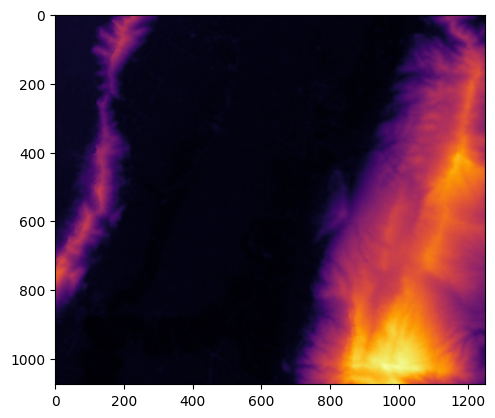

In [ ]:
plt.imshow(rs.open(ruta_arch_raster).read(1), cmap='inferno')
plt.show()

# 3. Despliegue de mapa interactivo con _leafmap_: ráster de Modelo Digital de Elevación

Se configura la visualización para que se ubique sobre el municipio de Chía y se genera la visualización del ráster con el mapa de contexto de CARTO.

In [ ]:
m1 = leafmap.Map( center=[mpio_chia.LONGITUD.tolist()[0], mpio_chia.LATITUD.tolist()[0]], zoom=3, pitch=0, bearing=0, style="positron")
m1.add_raster(ruta_arch_raster, colormap="terrain", name="DEM")

In [ ]:
m1

# 4. Despliegue de mapa interactivo con _leafmap_: extrusión de Modelo Digital de Elevación

Con ayuda de la librería _geowombat_, se aplica un submuestreo al raster con el propósito de hacer una visualización computacionalmente más ligera.

In [ ]:
%%capture
with gw.config.update(ref_res=1/1000):
  with gw.open(ruta_arch_raster, resampling="bilinear") as src:
    src.gw.to_raster(ruta_arch_ras_nu, overwrite=True, )

Se da un chequeo visual al ráster submuestreado. Se observa que disminuyó en su resolución.

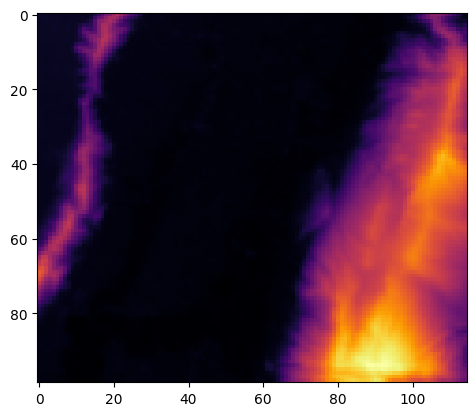

In [ ]:
plt.imshow(rs.open(ruta_arch_ras_nu).read(1), cmap='inferno')
plt.show()

La librería requiere que la capa de información sea convertida a un formato de datos tipo _json_. Se verifican los valores de los campos en la primera entrada de la capa de información.

In [ ]:
# pasar de raaster a vector
with rs.open(ruta_arch_ras_nu) as src:

  # Se recupera la banda que se va a convertir
  data = src.read(1, masked=True)

  # Se define un generador de geometriias y valores
  shape_gen = ((shape(s), v) for s, v in shapes(data, transform=src.transform))

  # Opcioon 1: Construye un pd.DataFrame (descomentar de ser necesario)
  #df = pd.DataFrame(shape_gen, columns=['geometry', 'class'])
  #gdf = gpd.GeoDataFrame(df["class"], geometry=df.geometry, crs=src.crs)

  # Opcioon 2: desempacar geometriias directamente en el GeoDataFrame
  gdf_desde_raster = gpd.GeoDataFrame(dict(zip(["geometry", "class"], zip(*shape_gen))), crs=src.crs).rename(columns={'class': "elevacion"})

In [ ]:
yeison_desde_raster = json.loads(gdf_desde_raster.to_json())

Se configura la capa de información para ser visualizada.

In [ ]:
m2 = leafmap.Map( center=[mpio_chia.LONGITUD.tolist()[0], mpio_chia.LATITUD.tolist()[0]], zoom=11, style="dark-matter", pitch=45, bearing=0)
paint_fill = {
    "fill-extrusion-color": {
        "property": "elevacion",
        "stops": [
            [2625, "green"],
            [2750, "yellow"],
            [2875, "orange"],
            [3000, "darkred"],
            [3125, "lightblue"],
            [3375, "blue"],
        ],
    },
    "fill-extrusion-height": ["get", "elevacion"],
    "fill-extrusion-opacity": 0.5,
}

m2.add_geojson(yeison_desde_raster, layer_type="fill-extrusion", paint=paint_fill, name="blocks-fill")
m2.to_html()
m2